**Name: Aakash Thatte          
Roll number: 12041590**

In [ ]:
# Importing libraries, some of them, I haven't even used, but good to have all at one place if needed.
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v
import random
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

In [ ]:
# I have earlier used the below hog() to extract features from training images and stored them in csv file
# hog(resize(image, (128,64)) , orientations=8, pixels_per_cell=(16, 16), 
#                     cells_per_block=(1, 1), visualize=False, multichannel=True)
# Here 8 is the number of bins that will be there in the histogram
# The small localized blocks will be of size (16,16), hence we used (128,64) shape.
# I came up with the above after tweaking its parameters and finding a suitable length feature vector, in this case, it is 256

training_hogs = pd.read_csv("/content/drive/MyDrive/Semester4/DS250/hog_256_all.csv")
# Reads in 46 seconds

In [ ]:
training_hogs.drop("Unnamed: 0",axis=1,inplace=True)
# Each column is a training image
# And values in that column are the feature vector(hog 256) of that image

In [ ]:
# Some helper functions, I may or may not have used these further in the notebook
def extract_class_name(col):
  options = col.split("_")
  print(options)

# for c in training_hogs.columns[3000:3550]:
#   extract_class_name(c)

In [ ]:
#training_hogs['kohlrabi_r_86_100.jpg'].values

In [ ]:
# Again, some helper code
fruit_class_training_folder = "/content/drive/MyDrive/Semester4/DS250/Training/Training_actual/Training/"
fruit_class_testing_folder = "/content/drive/MyDrive/Semester4/DS250/Training/Training_actual/Test/"
all_fruit_classes = os.listdir(fruit_class_training_folder)

def process_name(name):
  name = name.lower()
  names = name.split()
  return ("_").join(names)
  
all_class_names = []
for cl in all_fruit_classes:
  all_class_names.append(process_name(cl))

In [ ]:
# Similar to training_hogs, this csv file has hog 256 features of all 22688 testing images.
testing_hogs = pd.read_csv("/content/drive/MyDrive/Semester4/DS250/hog_256_test.csv")
# Finishes in 5 seconds

In [ ]:
testing_hogs

,Unnamed: 0,kohlrabi_32_100.jpg,kohlrabi_15_100.jpg,kohlrabi_r_137_100.jpg,kohlrabi_r_302_100.jpg,kohlrabi_r_292_100.jpg,kohlrabi_r_141_100.jpg,kohlrabi_r_163_100.jpg,kohlrabi_r_139_100.jpg,kohlrabi_r_303_100.jpg,kohlrabi_r_277_100.jpg,kohlrabi_228_100.jpg,kohlrabi_41_100.jpg,kohlrabi_225_100.jpg,kohlrabi_r_268_100.jpg,kohlrabi_46_100.jpg,kohlrabi_232_100.jpg,kohlrabi_r_13_100.jpg,kohlrabi_216_100.jpg,kohlrabi_r_7_100.jpg,kohlrabi_r_286_100.jpg,kohlrabi_r_285_100.jpg,kohlrabi_r_288_100.jpg,kohlrabi_48_100.jpg,kohlrabi_53_100.jpg,kohlrabi_45_100.jpg,kohlrabi_r_0_100.jpg,kohlrabi_218_100.jpg,kohlrabi_r_296_100.jpg,kohlrabi_r_142_100.jpg,kohlrabi_220_100.jpg,kohlrabi_39_100.jpg,kohlrabi_r_298_100.jpg,kohlrabi_r_129_100.jpg,kohlrabi_r_291_100.jpg,kohlrabi_r_287_100.jpg,kohlrabi_25_100.jpg,kohlrabi_36_100.jpg,kohlrabi_r_6_100.jpg,kohlrabi_r_289_100.jpg,...,kaki_7_100.jpg,kaki_257_100.jpg,kaki_r_78_100.jpg,kaki_294_100.jpg,kaki_161_100.jpg,kaki_r_173_100.jpg,kaki_r_159_100.jpg,kaki_r_185_100.jpg,kaki_8_100.jpg,kaki_267_100.jpg,kaki_279_100.jpg,kaki_r_151_100.jpg,kaki_275_100.jpg,kaki_r_175_100.jpg,kaki_r_176_100.jpg,kaki_r_190_100.jpg,kaki_283_100.jpg,kaki_r_191_100.jpg,kaki_r_137_100.jpg,kaki_r_155_100.jpg,kaki_11_100.jpg,kaki_266_100.jpg,kaki_288_100.jpg,kaki_r_172_100.jpg,kaki_155_100.jpg,kaki_252_100.jpg,kaki_185_100.jpg,kaki_r_146_100.jpg,kaki_r_144_100.jpg,kaki_263_100.jpg,kaki_r_76_100.jpg,kaki_286_100.jpg,kaki_268_100.jpg,kaki_269_100.jpg,kaki_r_152_100.jpg,kaki_r_85_100.jpg,kaki_r_193_100.jpg,kaki_r_166_100.jpg,kaki_0_100.jpg,kaki_r_182_100.jpg
0,0,0.0,0.000000,0.265984,0.486064,0.598229,0.471812,0.397428,0.494376,0.448017,0.430054,0.0,0.000000,0.0,0.471843,0.000000,0.0,0.519864,0.0,0.666162,0.584099,0.572046,0.590918,0.000000,0.000000,0.000000,0.647060,0.0,0.472749,0.497296,0.0,0.00000,0.382246,0.163523,0.576893,0.569448,0.000000,0.000000,0.573767,0.571603,...,0.507611,0.589025,0.363208,0.604583,0.419250,0.000000,0.375605,0.000000,0.578471,0.640936,0.536614,0.366565,0.535113,0.000000,0.000000,0.000000,0.545497,0.000000,0.473493,0.376812,0.639931,0.640262,0.609856,0.000000,0.406200,0.531139,0.413126,0.357435,0.353553,0.666270,0.378942,0.561956,0.666916,0.674682,0.353553,0.392281,0.000000,0.000000,0.609020,0.000000
1,1,0.0,0.000000,0.523908,0.486064,0.598229,0.471812,0.379771,0.494376,0.448017,0.328755,0.0,0.000000,0.0,0.471843,0.000000,0.0,0.519864,0.0,0.666162,0.584099,0.572046,0.590918,0.000000,0.000000,0.000000,0.150333,0.0,0.472749,0.497296,0.0,0.00000,0.382246,0.693681,0.576893,0.569448,0.000000,0.000000,0.573767,0.571603,...,0.507611,0.589025,0.277495,0.604583,0.347723,0.000000,0.375605,0.000000,0.578471,0.640936,0.536614,0.366565,0.535113,0.000000,0.000000,0.000000,0.545497,0.000000,0.502240,0.212538,0.639931,0.640262,0.609856,0.000000,0.406200,0.531139,0.400141,0.357435,0.353553,0.666270,0.259968,0.561956,0.666916,0.674682,0.353553,0.392281,0.000000,0.000000,0.609020,0.000000
2,2,0.0,0.000000,0.523908,0.343314,0.114014,0.471812,0.397428,0.494376,0.186007,0.282961,0.0,0.000000,0.0,0.471843,0.000000,0.0,0.519864,0.0,0.268089,0.235075,0.228892,0.312916,0.000000,0.000000,0.000000,0.055869,0.0,0.166642,0.497296,0.0,0.00000,0.382246,0.693681,0.232190,0.228445,0.000000,0.000000,0.100351,0.133093,...,0.087665,0.084224,0.363208,0.274520,0.387632,0.000000,0.375605,0.000000,0.122720,0.089940,0.062382,0.366565,0.115229,0.000000,0.000000,0.000000,0.107482,0.000000,0.502240,0.376812,0.115792,0.059723,0.100070,0.000000,0.361407,0.103191,0.391626,0.357435,0.353553,0.076647,0.378942,0.121855,0.138859,0.123194,0.353553,0.392281,0.000000,0.000000,0.234545,0.000000
3,3,0.0,0.000000,0.523908,0.111237,0.000000,0.471812,0.397428,0.494376,0.236495,0.124677,0.0,0.000000,0.0,0.096996,0.000000,0.0,0.055376,0.0,0.034288,0.051308,0.049958,0.081299,0.000000,0.000000,0.000000,0.192466,0.0,0.118122,0.497296,0.0,0.00000,0.260717,0.051751,0.050678,0.049861,0.000000,0.000000,0.028095,0.104487,...,0.210078,0.087135,0.363208,0.138439,0.201717,0.000000,

In [ ]:
testing_hogs.drop("Unnamed: 0",axis=1,inplace=True)

In [ ]:
# These are some csv files I used to keep watch on all image names and their class, it helps to find 
# class of an image using index further in the KNN code.
testing_img_label_df = pd.read_csv("/content/drive/MyDrive/Semester4/DS250/testing_image_label.csv")
training_img_label_df = pd.read_csv("/content/drive/MyDrive/Semester4/DS250/training_image_label.csv")

In [ ]:
training_columns = training_hogs.columns
testing_columns = testing_hogs.columns

In [ ]:
# This is a very naive implementation of KNN, which takes around 13-14 seconds
# per test image, which is quite slow. 
from collections import Counter
def pass_test_image(image_id,k):

  # Reading test hog features from dataframe
  test_hog = testing_hogs[image_id].values

  # Two dictionaries to store nearest neighbour and its distance
  nearest_k = {} # stores distance
  neighbours_k = {} # stores label/class
  # Initialize the dictionaries
  for i in range(1,k+1):
    nearest_k[i] = np.Inf
    neighbours_k[i] = None

  # Actual processing
  for i in range(len(training_columns)):
    col = training_columns[i]
    class_name = training_img_label_df.iloc[i]['label']
    
    train = training_hogs[col].values
    dist = np.linalg.norm(test_hog - train)
    for i in range(1,k+1):
      # Update the least k if any nearer neighbour is found
      if dist<nearest_k[i]:
        nearest_k[i] = dist
        neighbours_k[i] = class_name#col
        break
  # print(nearest_k)
  # print(neighbours_k)
  value, count = Counter(neighbours_k.values()).most_common(1)[0]
  # print(f"The prediction is {value} and its count in KNN (k={k}) is {count}")
  return value

In [ ]:
pass_test_image("kohlrabi_15_100.jpg",2) # Took 14 seconds to run for k=3 and k=2
# But it is predicting decently.

'kohlrabi'

In [ ]:
test_2 = "apple_red_3_4_100.jpg"
pass_test_image(test_2,3)

'apple_red_3'

In [ ]:
# Now we will use a DataFrame of test images to predict labels and see accuracy
test_images = pd.read_csv("/content/drive/MyDrive/Semester4/DS250/test_images_paths.csv")

In [ ]:
#small_test = test_images[:1500] , this I used while testing my code

In [ ]:
# I am using k=3 here, will test for more k later.
# This took quite a lot of time to run for only 50 test images, so I have later tried to use KDTree
predictions = []
labels_actual = []
images_test = testing_hogs.columns[:50]
for i in range(len(images_test)):
  if i%2==0:
    print(i*100,"images tested..") #------------------> wrote i*100 by mistake, so I processed 50 images, not 5000
  label = testing_img_label_df.iloc[i]['label']
  image_id = images_test[i]
  predictions.append(pass_test_image(image_id,k=3))
  labels_actual.append(label)

0 images tested..
200 images tested..
400 images tested..
600 images tested..
800 images tested..
1000 images tested..
1200 images tested..
1400 images tested..
1600 images tested..
1800 images tested..
2000 images tested..
2200 images tested..
2400 images tested..
2600 images tested..
2800 images tested..
3000 images tested..
3200 images tested..
3400 images tested..
3600 images tested..
3800 images tested..
4000 images tested..
4200 images tested..
4400 images tested..
4600 images tested..
4800 images tested..


In [ ]:
acc = pd.DataFrame(data={'actual':labels_actual,'predictions':predictions})
acc

,actual,predictions
0,kohlrabi,kohlrabi
1,kohlrabi,kohlrabi
2,kohlrabi,watermelon
3,kohlrabi,onion_white
4,kohlrabi,potato_white
5,kohlrabi,kohlrabi
6,kohlrabi,kohlrabi
7,kohlrabi,watermelon
8,kohlrabi,onion_white
9,kohlrabi,kohlrabi


In [ ]:
len(acc[acc['actual']==acc['predictions']])

35

In [ ]:
# So accuracy with KNN is around 70 percent (using 256 length hog feature vector) using my own code

In [ ]:
# Now I am using KDTree to check if it is fast enough and if it works well for me.

In [ ]:
# Loading all the training image hog features in a list/numpy array
kdData = []
for c in training_hogs.columns:
  kdData.append(training_hogs[c].values)
  # takes 3 seconds

In [ ]:
len(kdData)

67693

In [ ]:
# Trying KDTree
import scipy

In [ ]:
# KDTree works good, but due to large training data size, my colab notebook 
# crashed whenever I ran this partiular cell, so I was unable to use KDTree despite it being good.
kd = scipy.spatial.KDTree(data=kdData)

In [ ]:
indices = kd.query(testing_hogs['kohlrabi_32_100.jpg'].values,k=3)[1]
# This test worked well with KDTree

In [ ]:
# Here we can see that it found out three neighbours which coincidentally belonged to same class as our test image
# But it actually returns that class which occured most frequently in the k neighbours.
for i in indices:
  #print(training_hogs.columns[i])
  # To get the labels
  print(training_img_label_df.iloc[i]['label'])

kohlrabi_12_100.jpg
kohlrabi
kohlrabi_14_100.jpg
kohlrabi
kohlrabi_55_100.jpg
kohlrabi


In [ ]:
# for c in training_hogs.columns:
#     if np.sum(training_hogs[c].values-kdData[325])==0:
#       print(c)
#       break

kohlrabi_12_100.jpg


In [ ]:
test_images.head()

,Unnamed: 0,image,label,id
0,0,Apple Braeburn/3_100.jpg,apple_braeburn,apple_braeburn_3_100.jpg
1,1,Apple Braeburn/32_100.jpg,apple_braeburn,apple_braeburn_32_100.jpg
2,2,Apple Braeburn/321_100.jpg,apple_braeburn,apple_braeburn_321_100.jpg
3,3,Apple Braeburn/322_100.jpg,apple_braeburn,apple_braeburn_322_100.jpg
4,4,Apple Braeburn/323_100.jpg,apple_braeburn,apple_braeburn_323_100.jpg


In [ ]:
kdpred = []
tests = test_images['id'].values
for e,t in enumerate(tests):
  arr = kd.query(testing_hogs[t].values,k=3)[1]
  classes = [training_img_label_df.iloc[i]['label'] for i in arr]
  kdpred.append(Counter(classes).most_common(1)[0][0])
  if (e+1)%100==0:
    print(e+1,"Images processed")

# This will take around 3 hours for all test images, but due to colab RAM issue, I was unable to 
# run this on all test images, the below error is because the session crashed and I ran the cell 
# again and so kpred was new for it.

NameError: ignored

In [ ]:
def knn(x, X, k, **kwargs):
    """
    finds the indices of k-nearest neighbors of x in X
    """
    d = scipy.spatial.distance.cdist(x.reshape(1,-1), X, **kwargs).flatten()
    return np.argpartition(d, k)[:k]

In [ ]:
knn(testing_hogs['kohlrabi_32_100.jpg'].values,np.array(kdData),3)

array([326,  81, 106])

In [ ]:
training_img_label_df.iloc[326]['label'],training_img_label_df.iloc[81]['label']

('kohlrabi', 'kohlrabi')

In [ ]:
from collections import Counter
pred = []
tests = test_images['id'].values
for e,t in enumerate(tests):
  arr = knn(testing_hogs[t].values,np.array(kdData),3)
  classes = [training_img_label_df.iloc[i]['label'] for i in arr]
  pred.append(Counter(classes).most_common(1)[0][0])
  if (e+1)%100==0:
    print(e+1,"Images processed")

100 Images processed
200 Images processed
300 Images processed
400 Images processed
500 Images processed
600 Images processed
700 Images processed
800 Images processed
900 Images processed
1000 Images processed
1100 Images processed
1200 Images processed
1300 Images processed
1400 Images processed
1500 Images processed
1600 Images processed
1700 Images processed
1800 Images processed
1900 Images processed
2000 Images processed
2100 Images processed
2200 Images processed
2300 Images processed
2400 Images processed
2500 Images processed
2600 Images processed
2700 Images processed
2800 Images processed
2900 Images processed
3000 Images processed
3100 Images processed
3200 Images processed
3300 Images processed
3400 Images processed
3500 Images processed
3600 Images processed
3700 Images processed
3800 Images processed
3900 Images processed
4000 Images processed
4100 Images processed
4200 Images processed
4300 Images processed
4400 Images processed
4500 Images processed
4600 Images process

In [ ]:
test_images

,Unnamed: 0,image,label,id
0,0,Apple Braeburn/3_100.jpg,apple_braeburn,apple_braeburn_3_100.jpg
1,1,Apple Braeburn/32_100.jpg,apple_braeburn,apple_braeburn_32_100.jpg
2,2,Apple Braeburn/321_100.jpg,apple_braeburn,apple_braeburn_321_100.jpg
3,3,Apple Braeburn/322_100.jpg,apple_braeburn,apple_braeburn_322_100.jpg
4,4,Apple Braeburn/323_100.jpg,apple_braeburn,apple_braeburn_323_100.jpg
...,...,...,...,...
22683,22683,Watermelon/r_95_100.jpg,watermelon,watermelon_r_95_100.jpg
22684,22684,Watermelon/r_96_100.jpg,watermelon,watermelon_r_96_100.jpg
22685,22685,Watermelon/r_97_100.jpg,watermelon,watermelon_r_97_100.jpg
22686,22686,Watermelon/r_98_100.jpg,watermelon,watermelon_r_98_100.jpg


In [ ]:
test_images['predictions'] = pred

In [ ]:
test_images[test_images['label']==test_images['predictions']]

,Unnamed: 0,image,label,id,predictions
0,0,Apple Braeburn/3_100.jpg,apple_braeburn,apple_braeburn_3_100.jpg,apple_braeburn
1,1,Apple Braeburn/32_100.jpg,apple_braeburn,apple_braeburn_32_100.jpg,apple_braeburn
2,2,Apple Braeburn/321_100.jpg,apple_braeburn,apple_braeburn_321_100.jpg,apple_braeburn
3,3,Apple Braeburn/322_100.jpg,apple_braeburn,apple_braeburn_322_100.jpg,apple_braeburn
4,4,Apple Braeburn/323_100.jpg,apple_braeburn,apple_braeburn_323_100.jpg,apple_braeburn
...,...,...,...,...,...
22660,22660,Watermelon/r_71_100.jpg,watermelon,watermelon_r_71_100.jpg,watermelon
22661,22661,Watermelon/r_72_100.jpg,watermelon,watermelon_r_72_100.jpg,watermelon
22662,22662,Watermelon/r_73_100.jpg,watermelon,watermelon_r_73_100.jpg,watermelon
22669,22669,Watermelon/r_80_100.jpg,watermelon,watermelon_r_80_100.jpg,watermelon


In [ ]:
accuracy = 15781/22688
accuracy
# This is around 70 percent accuracy on complete dataset

0.6955659379407616

In [ ]:
test_images.to_csv("/content/drive/MyDrive/Semester4/DS250/knn_predictions_test_images.csv")
# Just saving the results as well, if needed sometime later

In [ ]:
# Now let us see which images were misclassified and why
miscl = test_images[test_images['label']!=test_images['predictions']]

In [ ]:
miscl.head()

,Unnamed: 0,image,label,id,predictions
39,39,Apple Braeburn/60_100.jpg,apple_braeburn,apple_braeburn_60_100.jpg,orange
41,41,Apple Braeburn/62_100.jpg,apple_braeburn,apple_braeburn_62_100.jpg,orange
46,46,Apple Braeburn/67_100.jpg,apple_braeburn,apple_braeburn_67_100.jpg,orange
101,101,Apple Braeburn/r_42_100.jpg,apple_braeburn,apple_braeburn_r_42_100.jpg,nectarine
103,103,Apple Braeburn/r_44_100.jpg,apple_braeburn,apple_braeburn_r_44_100.jpg,nectarine


In [ ]:
# Let us try to analyse the first one. Apple Braeburn/60_100.jpg, wrongly classified as orange
ind = knn(testing_hogs["apple_braeburn_60_100.jpg"].values,np.array(kdData),3)
for i in ind:
  for c in training_hogs.columns:
    if training_hogs.columns[i]==c:
      print(c)
# As we can see, all 3 neighbours that were considered near to this apple were oranges.

orange_227_100.jpg
orange_176_100.jpg
orange_159_100.jpg


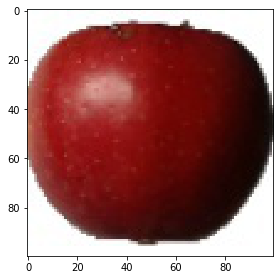

In [ ]:
imshow(fruit_class_testing_folder+"Apple Braeburn/60_100.jpg")

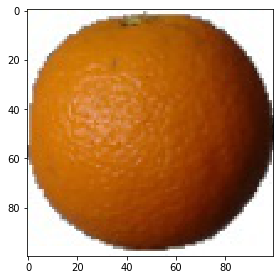

In [ ]:
imshow(fruit_class_training_folder+"Orange/227_100.jpg")

In [ ]:
# As we can see, the images look very different, let us see their hog features and find out where did we went wrong
h1, i1 = hog(resize(imread(fruit_class_testing_folder+"Apple Braeburn/60_100.jpg"), (128,64)) , orientations=8, pixels_per_cell=(16, 16), 
                 cells_per_block=(1, 1), visualize=True, multichannel=True)

h2, i2 = hog(resize(imread(fruit_class_training_folder+"Orange/227_100.jpg"), (128,64)) , orientations=8, pixels_per_cell=(16, 16), 
                   cells_per_block=(1, 1), visualize=True, multichannel=True)

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


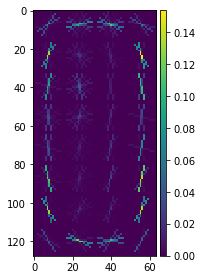

In [ ]:
imshow(i1)

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


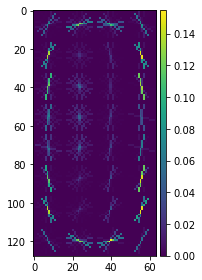

In [ ]:
imshow(i2)

In [ ]:
# As we can see from above, hog descriptor,
# it extracts gradient and orientation over localized portions of the image and thus accounts for the edges and their direction
# But I am unable to find why it classified as nearer than any apple.

1.4533441412786718

In [ ]:
# Using k=5 below, just to see if accuracy changes or not

In [ ]:
from collections import Counter
k5pred = []
tests = test_images['id'].values
for e,t in enumerate(tests):
  arr = knn(testing_hogs[t].values,np.array(kdData),5)
  classes = [training_img_label_df.iloc[i]['label'] for i in arr]
  k5pred.append(Counter(classes).most_common(1)[0][0])
  if (e+1)%1000==0:
    print(e+1,"Images processed")

1000 Images processed
2000 Images processed
3000 Images processed
4000 Images processed
5000 Images processed
6000 Images processed
7000 Images processed
8000 Images processed
9000 Images processed
10000 Images processed
11000 Images processed
12000 Images processed
13000 Images processed
14000 Images processed
15000 Images processed
16000 Images processed
17000 Images processed
18000 Images processed
19000 Images processed
20000 Images processed
21000 Images processed
22000 Images processed


In [ ]:
test_images['k5predictions'] = k5pred

In [ ]:
test_images.head()

,Unnamed: 0,image,label,id,k5predictions
0,0,Apple Braeburn/3_100.jpg,apple_braeburn,apple_braeburn_3_100.jpg,apple_braeburn
1,1,Apple Braeburn/32_100.jpg,apple_braeburn,apple_braeburn_32_100.jpg,apple_braeburn
2,2,Apple Braeburn/321_100.jpg,apple_braeburn,apple_braeburn_321_100.jpg,apple_braeburn
3,3,Apple Braeburn/322_100.jpg,apple_braeburn,apple_braeburn_322_100.jpg,apple_braeburn
4,4,Apple Braeburn/323_100.jpg,apple_braeburn,apple_braeburn_323_100.jpg,apple_braeburn


In [ ]:
len(test_images[test_images['label']==test_images['k5predictions']])

15630

In [ ]:
15630/22688 # k=5 gives a slightly less accuracy.

0.688910437235543